In [1]:
from aliases import *
import scanpy as sc

## Load Data

In [2]:
cond_colors = {
    "Control": "#f7ede2",
    "Bleo": "#fac522",
    "DMSO": "#d4d4d4",
    "Doxo": "#3f68b1",
    "Rad": "#d62828",
}

# pal = ["5fad56","f2c14e","f78154","4d9078","b4436c"]
pal = ["33658a","86bbd8","758e4f","f6ae2d","f26419"]
pal = [f'#{v}' for v in pal]
gene_set_to_color = {
    "GO": pal[0],
    "Fridman": pal[1],
    "SenMayo": pal[2],
    "CellAge": pal[3],
    "SenSet": pal[4],
}

In [3]:
adata = anndata.read_h5ad('data/Integrated-PCLS.h5ad')  # load the adata from the scVI step, ensure all genes have been inserted back after integration

## Plots

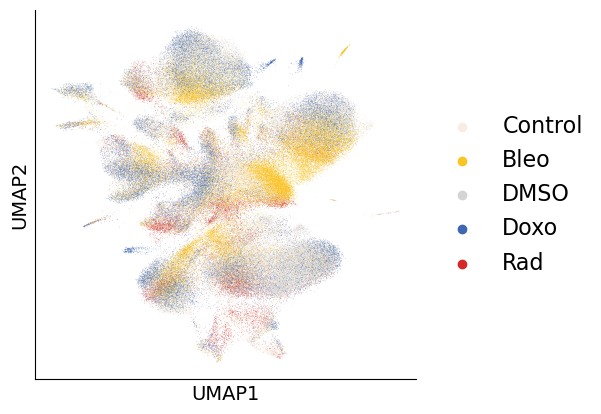

In [5]:
ax = sc.pl.umap(
    adata,
    color="cond",
    size=0.5,
    show=False,
    palette=cond_colors,
)

ax.collections[0].set_rasterized(True)
ax.set_title('')
colony.correct_font_size(ax)
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=16)
ax.set_aspect(0.8)
sns.despine(ax=ax)

# artist.savefig('figures/PCLS/main-umap.pdf')
plt.show()

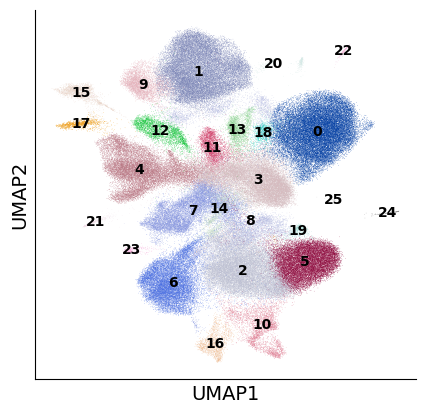

In [8]:
ax = sc.pl.umap(
    adata,
    color="leiden",
    size=0.5,
    show=False,
    legend_loc="on data",
)
ax.collections[0].set_rasterized(True)

ax.set_title('')
colony.correct_font_size(ax)
# sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=11, ncols=2)
ax.set_aspect(0.8)
sns.despine(ax=ax)

# artist.savefig('figures/PCLS/leiden-umap.pdf')
plt.show()

## CDKNxA Plots

In [ ]:
cdkn1a = adata[:, ['CDKN1A']].X.toarray().ravel()
cdkn2a = adata[:, ['CDKN2A']].X.toarray().ravel()

In [ ]:
for gene_name, gex in zip(['CDKN1A', 'CDKN2A'], [cdkn1a, cdkn2a]):
    cdknxa_bleo = np.where(adata.obs['batch_ID'].str.contains('bleo'), gex, np.nan)
    adata.obs[f'{gene_name}_Bleo'] = cdknxa_bleo
    cdknxa_doxo = np.where(adata.obs['batch_ID'].str.contains('doxo'), gex, np.nan)
    adata.obs[f'{gene_name}_Doxo'] = cdknxa_doxo
    cdknxa_control = np.where(adata.obs['batch_ID'].str.contains('control'), gex, np.nan)
    adata.obs[f'{gene_name}_Control'] = cdknxa_control
    cdknxa_dmso = np.where(adata.obs['batch_ID'].str.contains('dmso'), gex, np.nan)
    adata.obs[f'{gene_name}_DMSO'] = cdknxa_dmso
    cdknxa_rad = np.where(adata.obs['batch_ID'].str.contains('rad'), gex, np.nan)
    adata.obs[f'{gene_name}_Rad'] = cdknxa_rad

In [ ]:
cdkn1a_list = ["CDKN1A_Control", "CDKN1A_Bleo", "CDKN1A_DMSO", "CDKN1A_Doxo", "CDKN1A_Rad"]
cdkn2a_list = ["CDKN2A_Control", "CDKN2A_Bleo", "CDKN2A_DMSO", "CDKN2A_Doxo", "CDKN2A_Rad"]

In [ ]:
col = ps.Colony(font_size=20)

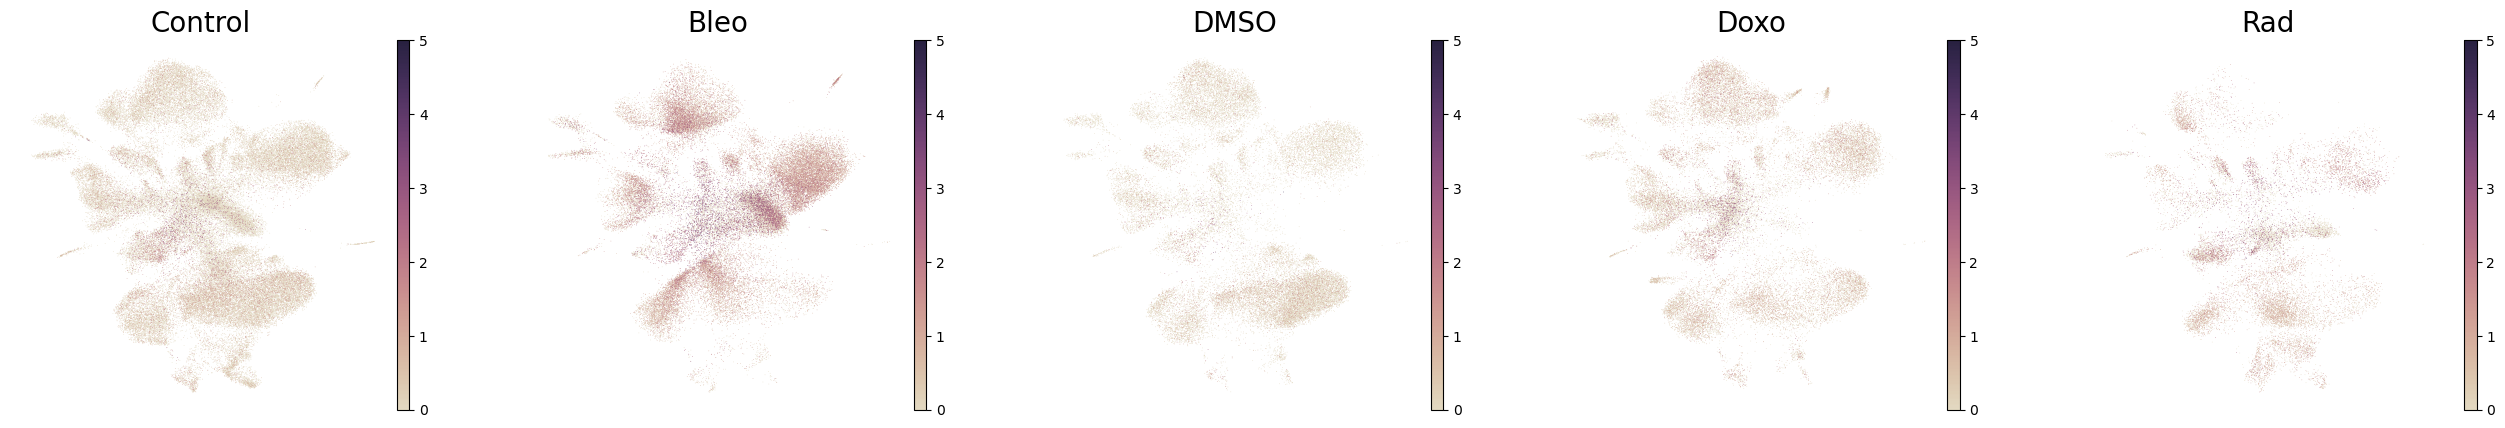

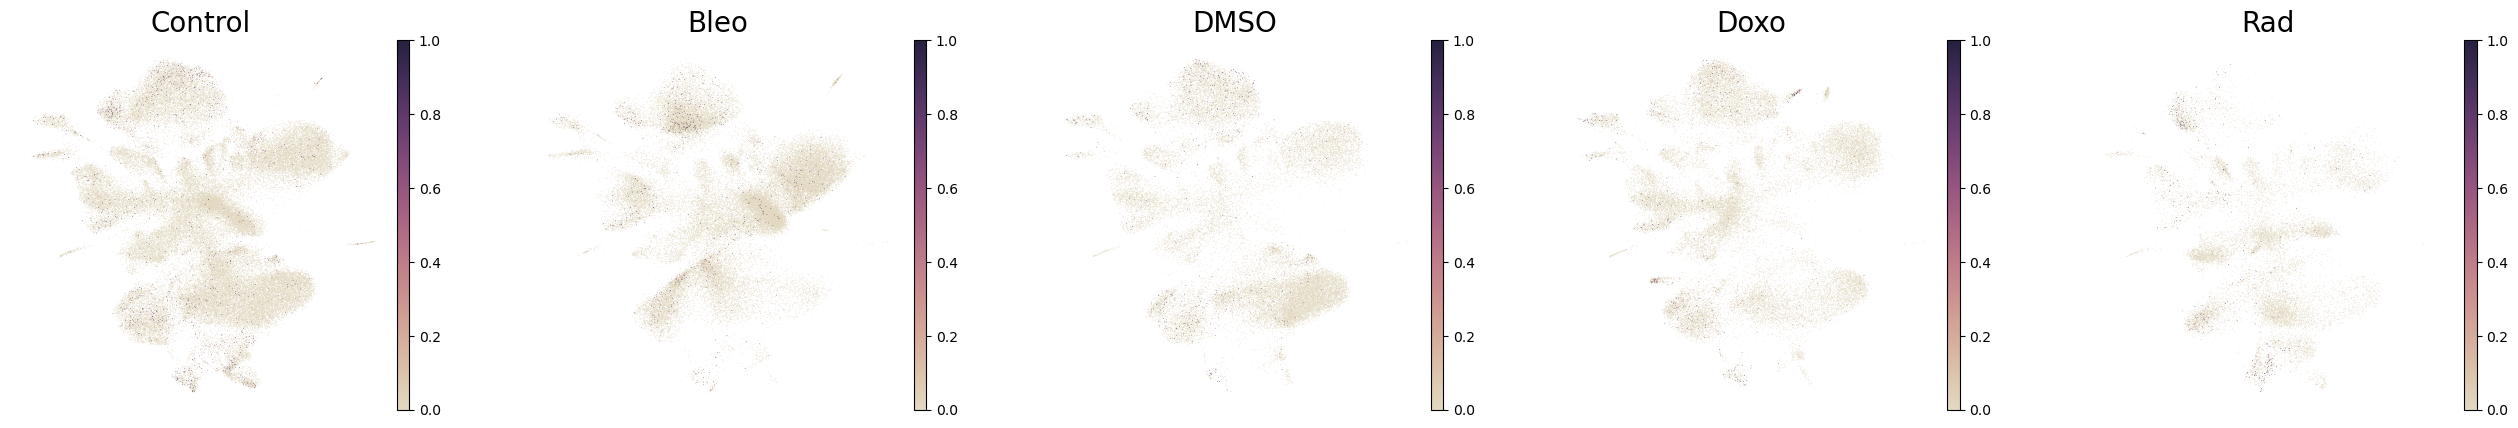

In [ ]:
for cdkn_list, gene_name, vmax in zip([cdkn1a_list, cdkn2a_list], ['CDKN1A', 'CDKN2A'], [5, 1]):
    axes = sc.pl.umap(
        adata,
        size=1,
        color=cdkn_list,
        color_map=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
        na_color='white',
        ncols=5,
        vmax=vmax,
        show=False,
        wspace=0.01,
    )

    for ax_i, ax in enumerate(axes):
        col.correct_font_size(ax)
        ax.set_aspect(0.8)
        sns.despine(ax=ax)
        title = ax.get_title()
        ax.set_title(title.split('_')[-1], fontsize=20)
        ax.collections[0].set_rasterized(True)

        sns.despine(ax=ax, left=True, bottom=True)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # artist.savefig(f'figures/PCLS/{gene_name}.pdf')
    plt.show()

## Marker Plots and Cell Type Annotation

In [9]:
def load_canonical_markers(adata, path='data/Lung-Cell-Type-Markers.xlsx'):
    markers = pd.read_excel(path)
    canonical_markers = {}

    for i, row in markers.iterrows():
        if pd.isna(row['Canonical markersb']):
            continue
        assert row['Cell type'] not in canonical_markers
        genes = row['Canonical markersb'].replace(' ', '').split(',')
        canonical_markers[row['Cell type']] = genes

    # Clean genes not found in adata
    good_genes = adata.var_names.tolist()
    for v in canonical_markers.values():
        for g in v.copy():
            if g not in good_genes:
                v.remove(g)
    # Remove any empty cell types
    for k in list(canonical_markers):
        if len(canonical_markers[k]) == 0:
            canonical_markers.pop(k)

    return canonical_markers

In [10]:
canonical_markers = load_canonical_markers(adata)

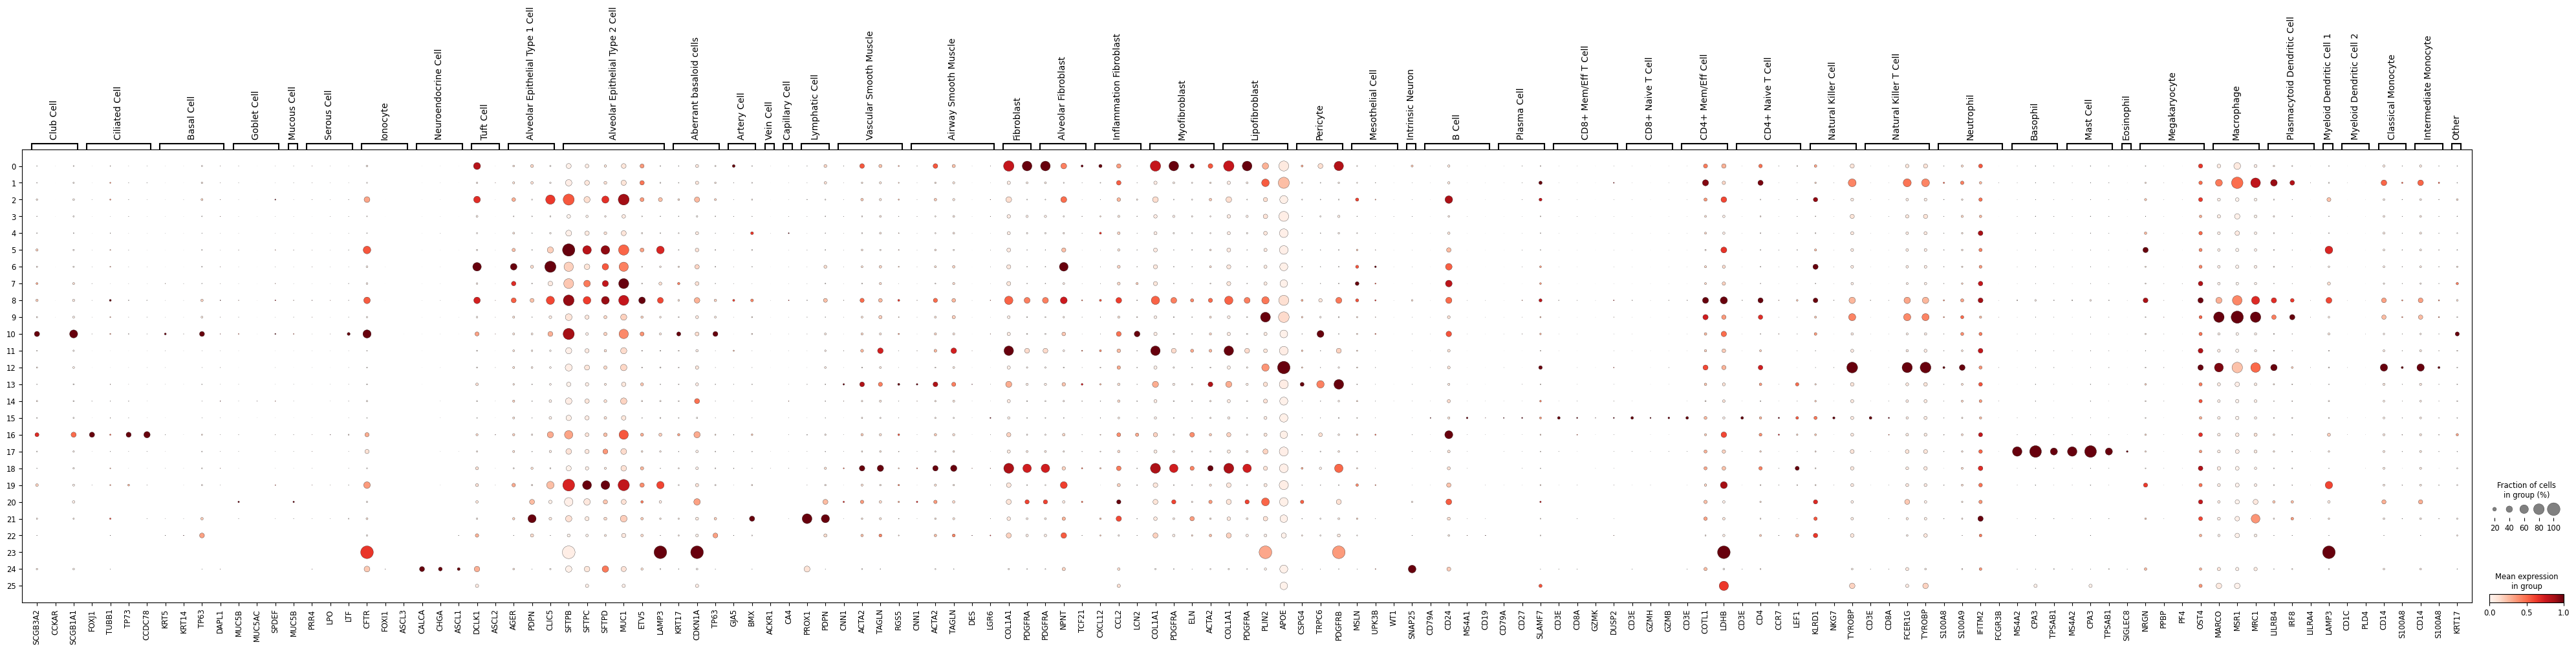

In [12]:
ax = sc.pl.dotplot(
    adata[adata.obs['condition'] == 'Control'],
    canonical_markers,
    groupby="leiden",
    standard_scale="var",
    show=False,
)

# artist.savefig('figures/PCLS/marker-dotplot-split2.pdf')
plt.show()

In [13]:
adata.obs['cell_type'] = pd.Categorical(adata.obs['leiden'].map({
    "0": "Fibroblast",
    "1": "Macrophage",
    "2": "AT2",
    "3": "NA",
    "4": "NA",
    "5": "AT2",
    "6": "AT1",
    "7": "AT2",
    "8": "Transient AEC",
    "9": "Monocyte",
    "10": "Club Cell",
    "11": "Fibroblast",
    "12": "Natural Killer Cell",
    "13": "Pericyte",
    "14": "NA",
    "15": "NA",
    "16": "Ciliated Cell",
    "17": "Mast Cell",
    "18": "Myofibroblast",
    "19": "AT2",
    "20": "NA",
    "21": "Lymphatic Cell",
    "22": "NA",
    "23": "AT2",
    "24": "NA",
    "25": "NA",
}))

/home/euxhenh/micromamba/envs/ml10/lib/python3.10/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


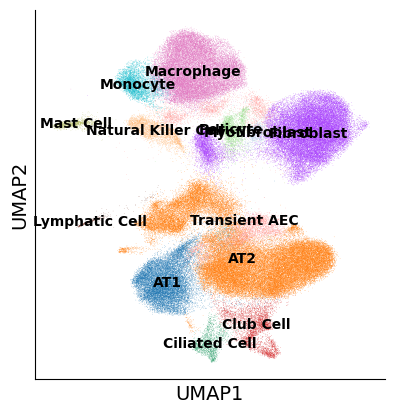

In [14]:
ax = sc.pl.umap(
    adata[adata.obs['cell_type'] != 'NA'],
    color="cell_type",
    size=0.5,
    show=False,
    legend_loc="on data",
)
ax.collections[0].set_rasterized(True)

ax.set_title('')
colony.correct_font_size(ax)
# sns.move_legend(ax, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=11, ncols=2)
ax.set_aspect(0.8)
sns.despine(ax=ax)

# artist.savefig('figures/PCLS/cell_type-umap.pdf')
plt.show()

## Find markers

In [15]:
from senset import SncGeneSets
from scipy.stats import ranksums, hypergeom
from statsmodels.stats.multitest import multipletests

In [16]:
extension = "SNC-known-pca=10-prior=0.9-no-smoker"

In [17]:
SNC = SncGeneSets(
    SenSet=f'dumps/SenSet-{extension}.txt',
    remove_downregulated=False,
)
gene_sets = SNC.gene_sets
print(SNC)

Gene Set module with keys:
	GO: 83
	Fridman: 90
	SenMayo: 125
	CellAge: 279
	union: 501
	SenSet: 106



In [ ]:
tests_df = []
use_adata = True

to_use = adata if use_adata else adata[adata.obs['cell_type'] != '']


for gene_set in tqdm(gene_sets):
    for cell_type in npu(to_use.obs['cell_type']):
        common_genes = npi(getattr(SNC, gene_set), to_use.var_names)
        _adata = to_use[to_use.obs['cell_type'] == cell_type, common_genes]
        idx_control = np.argwhere(_adata.obs['condition'] == 'Control').ravel()
        idx_treat = np.argwhere(_adata.obs['condition'] == 'Treatment').ravel()
        if idx_control.size < 30 or idx_treat.size < 30:
            print(f"Not enough cells for {cell_type}")
            continue

        test = ranksums(_adata.X[idx_treat].toarray(), _adata.X[idx_control].toarray())
        pval = np.clip(test.pvalue, 1e-100, None)
        fdr = multipletests(pval)[1]
        test_df = pd.DataFrame(data={
            "Cell Type": cell_type,
            "Gene": _adata.var_names.to_numpy(),
            "Statistic": test.statistic,
            "P": test.pvalue,
            "FDR": fdr,
            "Gene Set": gene_set,
            "$-\log($FDR$)$": -np.log10(np.clip(fdr, 1e-100, None)),
        })
        tests_df.append(test_df)

tests_df = pd.concat(tests_df)

## Combined p-values

In [20]:
from scipy.stats import combine_pvalues

In [21]:
cpvals = []

for gene_set, gs_df in tests_df.groupby('Gene Set'):
    for cell_type, ct_df in gs_df.groupby('Cell Type'):
        stat, pval = combine_pvalues(ct_df['P'], method='pearson')
        cpvals.append({
            "Gene Set": gene_set,
            "Cell Type": cell_type,
            "Statistic": stat,
            "Combined P": pval,
        })
cpvals = pd.DataFrame(cpvals)
cpvals['$-\log_{10}($Combined $P)$'] = -np.log10(np.clip(cpvals['Combined P'], 1e-100, None))

/home/euxhenh/micromamba/envs/ml10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9327: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))
/home/euxhenh/micromamba/envs/ml10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9327: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))
/home/euxhenh/micromamba/envs/ml10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9327: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))
/home/euxhenh/micromamba/envs/ml10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9327: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))


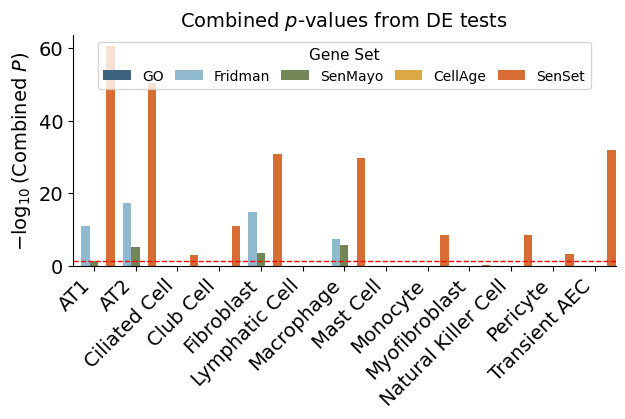

In [23]:
fig, ax = plt.subplots(figsize=(7, 3))

sns.barplot(
    cpvals[cpvals['Cell Type'] != 'NA'],
    # col='Cell Type',
    # col_wrap=4,
    # kind='bar',
    hue='Gene Set',
    hue_order=list(gene_set_to_color),
    palette=gene_set_to_color,
    y='$-\log_{10}($Combined $P)$',
    width=1,
    x='Cell Type',
    ax=ax,
)

colony.correct_font_size(ax)
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)

ax.set_xlabel('')
ax.axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=1)
sns.despine(ax=ax)
sns.move_legend(ax, loc='upper center', ncols=5, fontsize=10, title_fontsize=11, columnspacing=0.8)
ax.set_title('Combined $p$-values from DE tests', fontsize=14)

# artist.savefig('figures/PCLS/combined-p.pdf')
plt.show()

## Cell type markers heatmaps

In [22]:
dd_stat = {}
dd_fdr = {}

for gene_set, _df in tests_df.groupby("Gene Set"):
    dd_1 = _df.pivot_table(values="Statistic", columns="Gene", index="Cell Type")
    dd_2 = _df.pivot_table(values="FDR", columns="Gene", index="Cell Type")
    dd_stat[gene_set] = (dd_1, dd_2)

In [24]:
gene_to_set = defaultdict(list)

for gene in SNC.SenSet:
    for gs in gene_sets[:-1]:
        if gene in getattr(SNC, gs):
            gene_to_set[gene].append(gs)

In [ ]:
for gene_set, dd_pair in dd_stat.items():
    # SenSet
    dd = dd_pair[0]
    arr = np.zeros_like(dd).astype(object)
    arr[dd_pair[1] < 0.05] = '*'
    arr[arr == 0] = ''
    # arr[dd >= 0.05] = 'ns'
    if gene_set == 'SenSet':
        col_names = [gene_set_to_color[gene_to_set[g][0]] if len(gene_to_set[g]) == 1 else gene_set_to_color['SenSet'] for g in dd.columns ]
    else:
        col_names = None

    cg = sns.clustermap(
        dd.T,
        center=0,
        cmap=sns.color_palette("vlag", as_cmap=True),
        annot=arr.T,
        row_colors=col_names,
        fmt="",
        figsize=(10, 30 if gene_set != 'SenMayo' else 34),
        vmax=20,
        vmin=-20,
    )
    cg.ax_heatmap.set_ylabel(gene_set, fontsize=20)
    for label in cg.ax_heatmap.get_xticklabels():
            label.set_ha("right")
            label.set_rotation(45)

    artist.savefig(f'figures/PCLS/CellTypes/cell-type-markers-{gene_set}.pdf')
    plt.clf()

<Figure size 1000x3000 with 0 Axes>

<Figure size 1000x3000 with 0 Axes>

<Figure size 1000x3000 with 0 Axes>

<Figure size 1000x3400 with 0 Axes>

<Figure size 1000x3000 with 0 Axes>